## FIXED: Something is really wrong with the filtering. Lets find out what
The issue was that when using `utils.py:smooth_input_datasets` the fields were not actually smoothed but the amplitude was massively enhanced (from O(100) to O(1e40). 

In [1]:
import json
import gcsfs
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from dask.distributed import Client, LocalCluster
import dask
import zarr
from dask.diagnostics import ProgressBar

from utils import smooth_inputs, smooth_inputs_dataset
from cm26_utils import load_and_combine_cm26

# set up gcs filesystem
# 👇 replace with your key 
with open( '/home/jovyan/KEYS/pangeo-forge-ocean-transport-4967-347e2048c5a1.json') as token_file:
    token = json.load(token_file)
fs = gcsfs.GCSFileSystem(token=token)

## First lets look if the old velocities were properly filtered (✅ YES)

In [2]:
ds_raw = load_and_combine_cm26(fs)

Load Data



KeyboardInterrupt



In [3]:
path = 'ocean-transport-group/scale-aware-air-sea/preprocessed/CM26_smoothed_split_v2.zarr'
ds_smooth = xr.open_dataset(fs.get_mapper(path), engine='zarr', consolidated=True, chunks={})

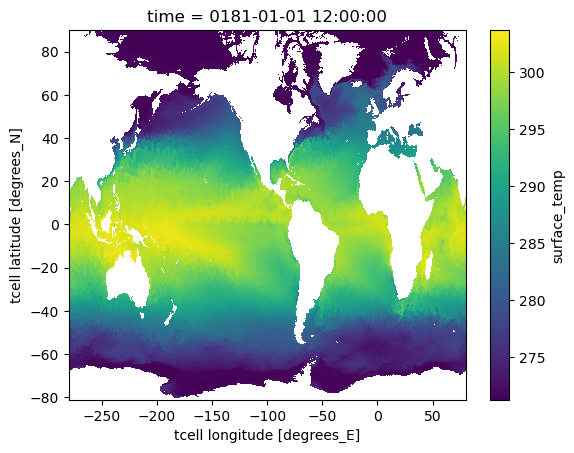

In [4]:
ds_raw['surface_temp'].isel(time=0).plot()

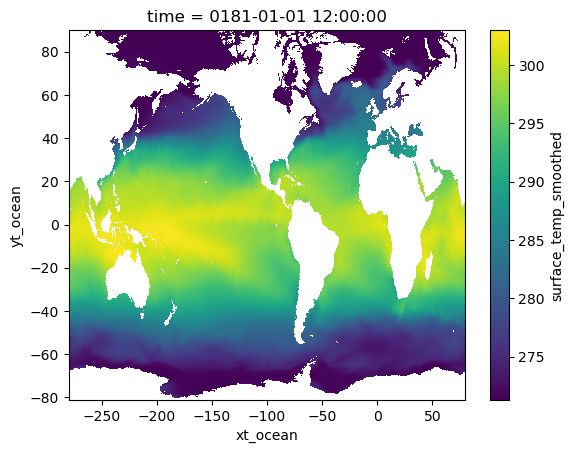

In [5]:
ds_smooth['surface_temp_smoothed'].isel(time=0).plot(x='xt_ocean')

Ok this clearly worked! So why is it not working on the results that we saved?

In [3]:
path = 'ocean-transport-group/scale-aware-air-sea/results/cm26_flux_long_term_mean_v2.zarr'
ds = xr.open_dataset(fs.get_mapper(path), engine='zarr', consolidated=True, chunks={})

In [7]:
# cut just a small area so we can see the smoothing better
ds = ds.isel(xt_ocean=slice(0,500), yt_ocean=slice(0,1000))

In [8]:
ds_smooth = smooth_inputs_dataset(ds, ['yt_ocean', 'xt_ocean'], 50)

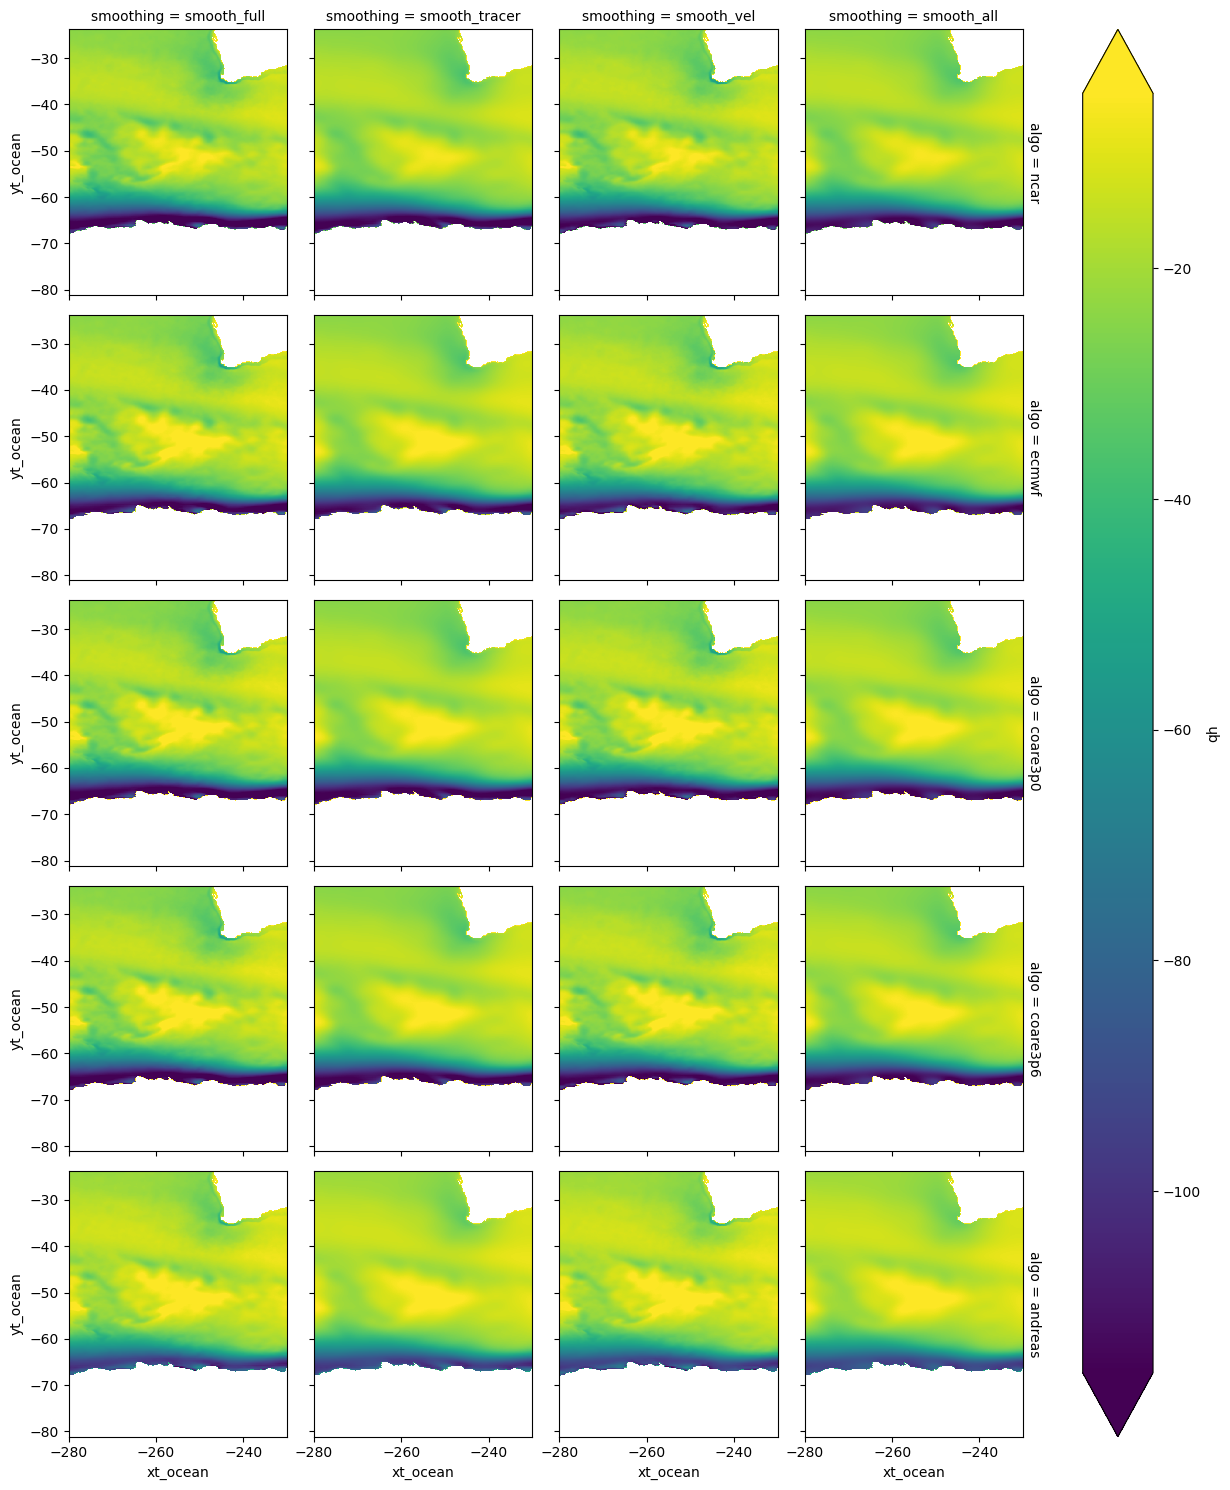

In [9]:
ds['qh'].plot(col='smoothing', row='algo', robust=True)

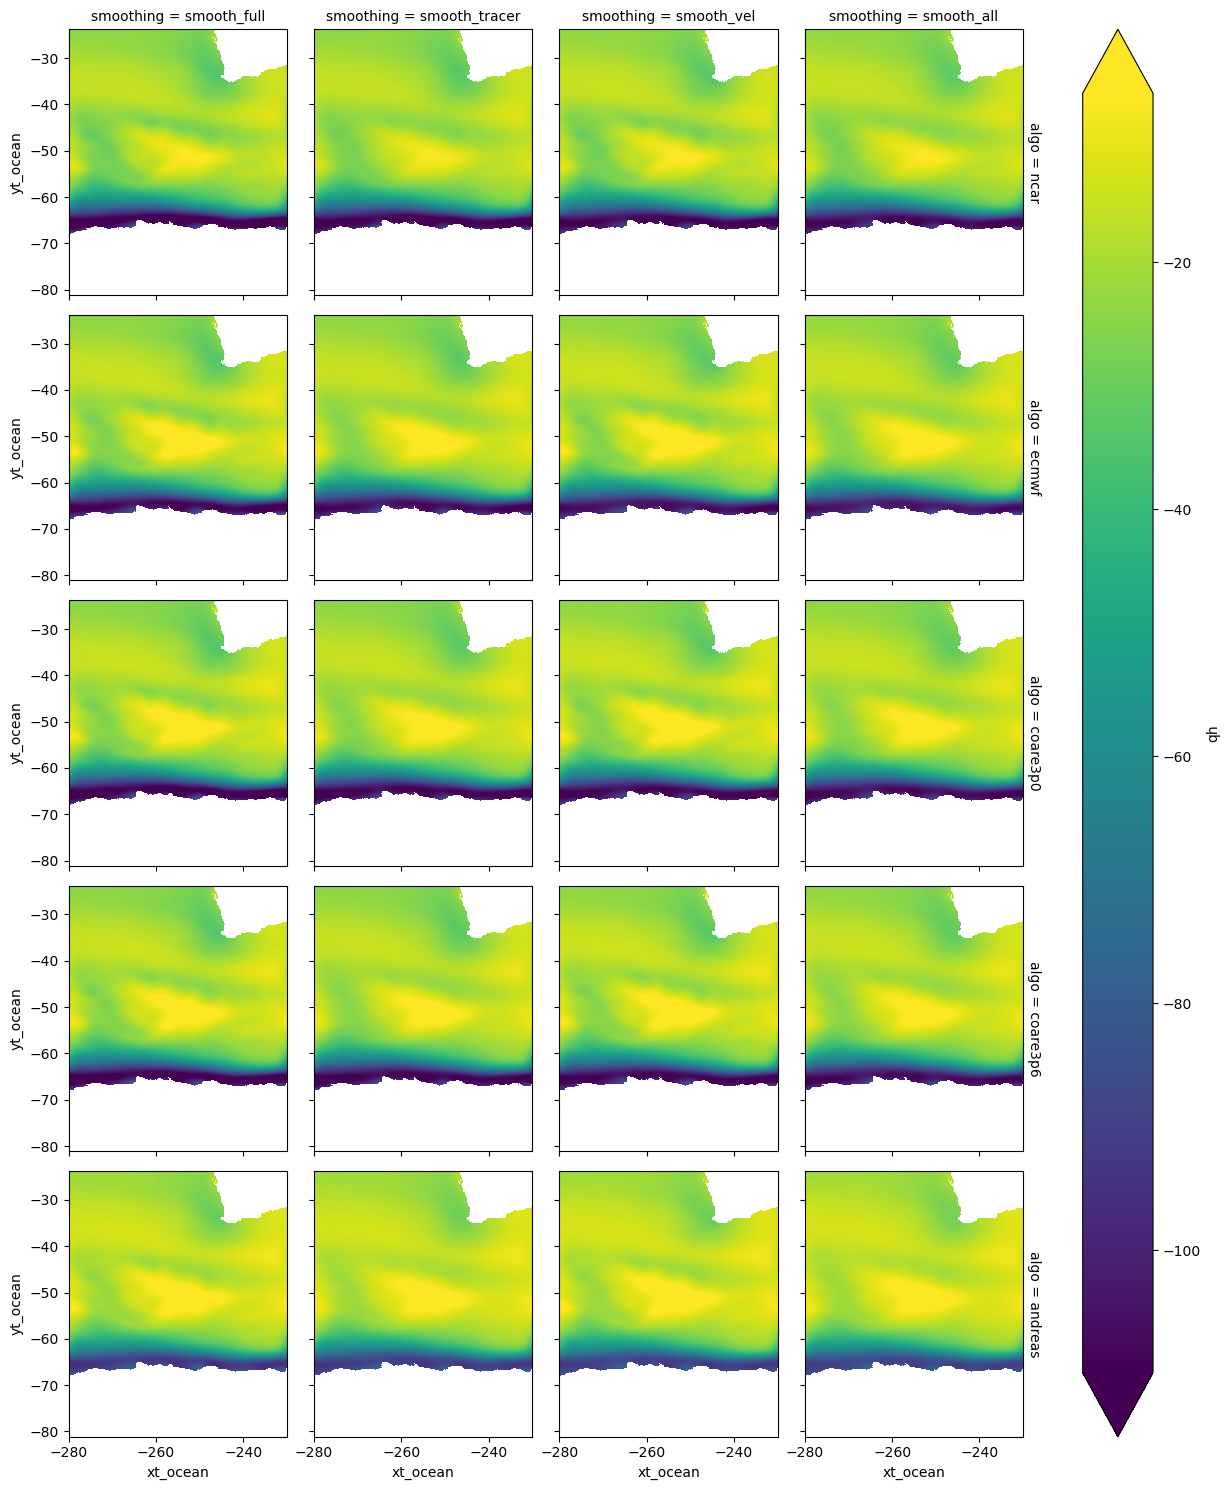

In [10]:
ds_smooth['qh'].plot(col='smoothing', row='algo', robust=True)

## These are now properly smoothed

The issue was the line
```python
wet_mask = ~np.isnan(mask_da).astype(int)
```
in `utils.py:smooth_inputs_dataset` (which was not used in the original `cm26_combine_filter_inputs.ipynb`). Replacing that with
```python
wet_mask = (~np.isnan(mask_da)).astype(int)
```
fixed the issue